# Test SEBlocks

In [1]:
from config import nn, torch
optim = torch.optim
DataLoader = torch.utils.data.DataLoader
random_split = torch.utils.data.random_split
from tqdm import tqdm
from torchvision.transforms import v2

from config import device, dataset_dir, output_dir, classes, batch_size, learning_rate, num_epochs, device
from helpers import process_dataset
from dataset_classes import VideoDataset
from model_class import DynamicOpticalFlowRecognizer

In [2]:
# process_dataset(dataset_dir, output_dir, frame_interval=1, max_workers=None)

## Model Training and such

### Image Transformations

In [3]:
default_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(256, 256), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

default_transform 

Compose(
      ToImage()
      Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

### Load Data

In [4]:
data = VideoDataset(dataset_dir, transform=default_transform, keyframe_threshold=.01, classes_=classes)

In [5]:
train_set, test_set = random_split(data, [int(len(data) * .8), len(data) - int(len(data) * .8)])

In [6]:
len(train_set), len(test_set)

(235, 59)

In [7]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
len(train_loader), len(test_loader)

(117, 29)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


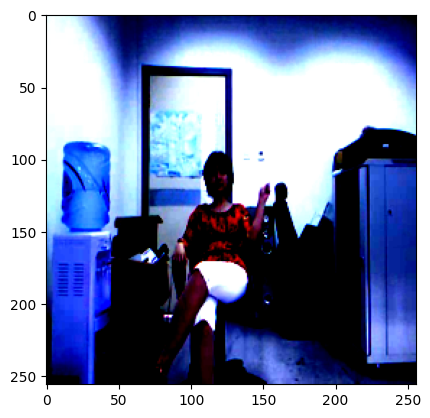

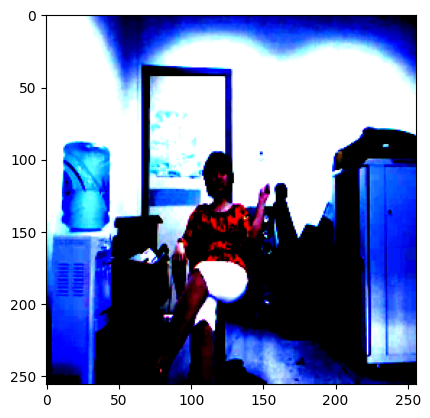

In [57]:
from matplotlib import pyplot as plt

plt.show(plt.imshow(train_set.__getitem__(6)[0].permute(1, 2, 0)))
glare_removal_transform = v2.Compose([
    v2.ColorJitter(contrast=.9),
])

glare_removed_image = glare_removal_transform(train_set.__getitem__(6)[0])
plt.show(plt.imshow(glare_removed_image.permute(1, 2, 0)))
plt.show()

### Train

In [9]:
model = DynamicOpticalFlowRecognizer(num_classes=len(classes)).to(device)
model

DynamicOpticalFlowRecognizer(
  (spatial): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 7), stride=(1, 1), padding=(1, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): SEBlock(
      (pool): AdaptiveAvgPool2d(output_size=1)
      (conv1): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
      (activ_func): ReLU(inplace=True)
      (conv2): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
      (sigmoid): Sigmoid()
    )
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): SEBlock(
      (pool): AdaptiveAvgPool2d(output_size=1)
      (conv1): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
      (activ_func): ReLU(inplace=True)
      (conv2): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
      (sig

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [15]:
# epochs of size 10
for epoch in tqdm(range(num_epochs // 10)):
    for _ in range(10):
        model.train()
        for _, (point) in enumerate((train_loader)):
            key_frame_data, optical_flow_data, labels = point

            key_frame_data = key_frame_data.to(device)    
            optical_flow_data = optical_flow_data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(key_frame_data, optical_flow_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

        # validate
        model.eval()    

    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for key_frames, optical_flows, labels in test_loader:
            key_frames_data = key_frames.to(device)
            optical_flows_data = optical_flows.to(device)
            labels = labels.to(device)      
            
            outputs = model(key_frames_data, optical_flows_data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()            
        
        print(f"Validation Loss: {val_loss/len(test_set):.4f}, Accuracy: {100 * correct / total:.2f}%")

  0%|          | 1/1000 [00:44<12:18:01, 44.33s/it]

Validation Loss: 1.2216, Accuracy: 6.90%


  0%|          | 2/1000 [01:28<12:20:38, 44.53s/it]

Validation Loss: 1.2216, Accuracy: 6.90%


  0%|          | 2/1000 [01:59<16:30:17, 59.54s/it]


KeyboardInterrupt: 

In [25]:
torch.save(model.state_dict(), "model.pth")